In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os
import itertools
import joblib
from datetime import datetime

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Replicamos las funciones esenciales para asegurar la ejecución del pipeline completo.
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1
    elif 8 <= mes <= 12:
        return 2
    else:
        return 0

def semana_en_semestre(row):
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

In [3]:
try:
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/daily_counts_full.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'daily_counts_full.csv'.")
    exit(1)

# A. Feature Engineering (Repetimos los pasos para un DF limpio)
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)
daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 
].reset_index(drop=True)

daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])


# B. Preparación del DF en formato Prophet (ds, y)
data_prophet = daily_counts_full.set_index('Fecha').dropna().copy()
data_prophet.rename(columns={'Accesos': 'y'}, inplace=True)
data_prophet['ds'] = data_prophet.index

# Conjunto completo de features (exógenas/regresores)
FEATURES = ['Semana_Certamen', 'media_movil_7', 'media_movil_14', 'media_movil_30',
            'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
            'lag_7', 'lag_14', 'lag_21', 'ewma_7', 'ewma_14', 'ewma_30']

# C. División de datos original (sin Augmentation)
split_point = int(len(data_prophet) * 0.8)

train_df = data_prophet.iloc[:split_point]
test_df = data_prophet.iloc[split_point:]

y_test = test_df['y']
X_test = test_df.drop(columns=['y'])


print(f"\n--- Preparación de Datos Finalizada ---")
print(f"Prophet: Datos de entrenamiento: {len(train_df)} | Datos de prueba: {len(test_df)}")

Dataset cargado desde 'Datasets/daily_counts_full.csv'

--- Preparación de Datos Finalizada ---
Prophet: Datos de entrenamiento: 256 | Datos de prueba: 64


In [4]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],  # Flexibilidad de la tendencia
    'seasonality_prior_scale': [1.0, 10.0]  # Fuerza de la estacionalidad
}

# Generar todas las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
best_rmse = float("inf")
best_params = None

print("\nIniciando ajuste de hiperparámetros de Prophet...")

for params in all_params:
    try:
        # 1. Crear y entrenar el modelo
        m = Prophet(**params, 
                    weekly_seasonality=True, 
                    daily_seasonality=False,
                    yearly_seasonality=True,
                    seasonality_mode='multiplicative')
        
        # Añadir las variables exógenas
        for feature in FEATURES:
            m.add_regressor(feature)
            
        m.fit(train_df)
        
        # 2. Predecir en el set de prueba
        future = test_df[['ds'] + FEATURES]
        forecast = m.predict(future)
        
        # 3. Calcular RMSE
        predicted = np.maximum(forecast['yhat'], 0).values
        rmse = np.sqrt(mean_squared_error(y_test, predicted))
        
        rmses.append(rmse)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
        
        print(f"Prophet {params} RMSE: {rmse:.2f}")

    except Exception as e:
        print(f"Error con parámetros {params}: {e}")
        continue

print(f'\nMejores parámetros para Prophet: {best_params}')


Iniciando ajuste de hiperparámetros de Prophet...


22:03:55 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1] done processing
22:03:55 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0} RMSE: 1000.81
Prophet {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0} RMSE: 1056.64


22:03:55 - cmdstanpy - INFO - Chain [1] start processing
22:03:56 - cmdstanpy - INFO - Chain [1] done processing
22:03:56 - cmdstanpy - INFO - Chain [1] start processing
22:03:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0} RMSE: 1878.41
Prophet {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0} RMSE: 2021.04

Mejores parámetros para Prophet: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [5]:
# Entrenamiento del Modelo Final y Evaluación 

print("\nEntrenando modelo Prophet final con los mejores parámetros...")
model_prophet = Prophet(**best_params, 
                          weekly_seasonality=True, 
                          daily_seasonality=False,
                          yearly_seasonality=True,
                          seasonality_mode='multiplicative')

for feature in FEATURES:
    model_prophet.add_regressor(feature)

model_prophet.fit(train_df)

# Predicción
future = test_df[['ds'] + FEATURES]
forecast = model_prophet.predict(future)
prophet_predicted = np.maximum(forecast['yhat'], 0).values

# Cálculo de métricas
mse = mean_squared_error(y_test, prophet_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, prophet_predicted)
r2 = r2_score(y_test, prophet_predicted)

print("\n--- Evaluación de rendimiento de Prophet en el set de prueba ---")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

22:03:56 - cmdstanpy - INFO - Chain [1] start processing
22:03:56 - cmdstanpy - INFO - Chain [1] done processing



Entrenando modelo Prophet final con los mejores parámetros...

--- Evaluación de rendimiento de Prophet en el set de prueba ---
R²: 0.54
Error Cuadrático Medio (MSE): 1001619.43
Error Cuadrático Medio Raíz (RMSE): 1000.81
Error Absoluto Medio (MAE): 675.51


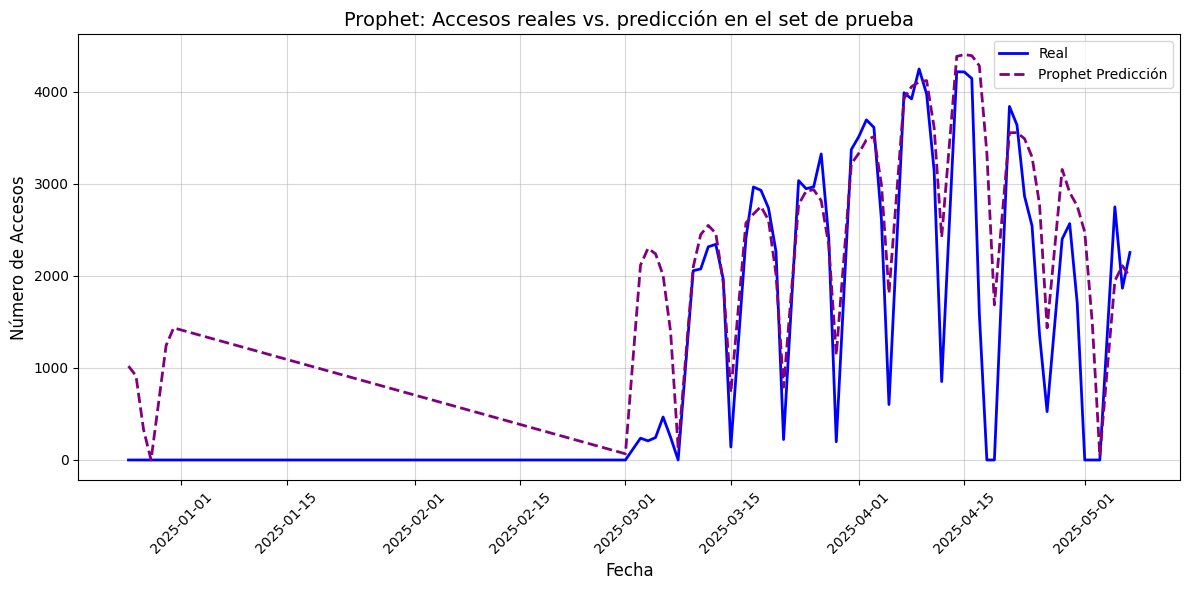


Se ha generado la visualización de la predicción de Prophet.


In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='blue', linewidth=2)
plt.plot(y_test.index, prophet_predicted, label='Prophet Predicción', color='purple', linestyle='--', linewidth=2)
plt.title('Prophet: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

print("\nSe ha generado la visualización de la predicción de Prophet.")